In [220]:
import csv
import random
import math
import operator

import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from pandas.plotting import scatter_matrix

## Comparing Apple's stock with competitors' stocks

This segment will analyse on how our model's company (Apple) performs in relative with its competitors, and whether we can use similar approaches to predict those stocks.

In [221]:
stock_apple = 'aapl'
stock_mik = 'mik'
stock_ypf = 'ypf'

df_aapl = pd.read_csv('%s.us.txt' % stock_apple, index_col=0)
df_aapl.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless

df_mik = pd.read_csv('%s.us.txt' % stock_mik, index_col=0)
df_mik.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless

df_ypf = pd.read_csv('%s.us.txt' % stock_ypf, index_col=0)
df_ypf.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless

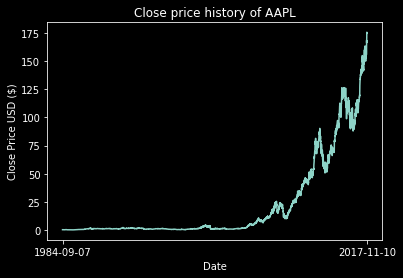

In [222]:
# Visualize closing price history
plt.title('Close price history of %s' % stock_apple.upper())
plt.plot(df_aapl['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df_aapl.index.values)[0], list(df_aapl.index.values)[-1]])
plt.show()

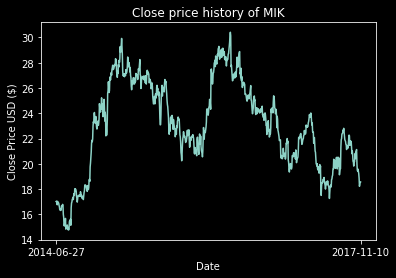

In [223]:
# Visualize closing price history
plt.title('Close price history of %s' % stock_mik.upper())
plt.plot(df_mik['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df_mik.index.values)[0], list(df_mik.index.values)[-1]])
plt.show()

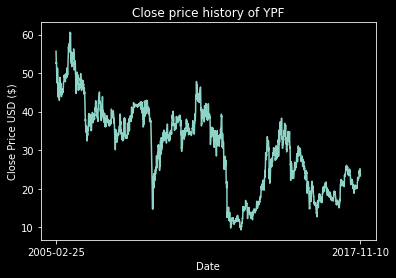

In [224]:
# Visualize closing price history
plt.title('Close price history of %s' % stock_ypf.upper())
plt.plot(df_ypf['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df_ypf.index.values)[0], list(df_ypf.index.values)[-1]])
plt.show()

## Feature Engineering

We will use K Nearest Neighbor (KNN) to predict our stocks. 

We will first engineer 3 new features: High Low Percentage, Percentage Change and Monthly Percentage Change.

### 1. Apple

Regression

In [225]:
dfreg_aapl = df_aapl.loc[:,['Close','Volume']]
dfreg_aapl['HL_Percent'] = (df_aapl['High'] - df_aapl['Low']) / df_aapl['Close'] * 100.0
dfreg_aapl['Percent_Change'] = (df_aapl['Close'] - df_aapl['Open']) / df_aapl['Open'] * 100.0
dfreg_aapl['Month_Percent_Change'] = (df_aapl['Close'] - df_aapl['Close'].shift(30)) / df_aapl['Close'] * 100.0

# Drop missing value
dfreg_aapl.dropna(subset= ['Month_Percent_Change'], inplace=True)

# How many days to forcast (1, 5, 30)
forecast_out = 30

# Separating the label here, we want to predict the future Close
forecast_col = 'Close'
dfreg_aapl['Label'] = dfreg_aapl[forecast_col].shift(-forecast_out)

dfreg_aapl.head(-10)

,Close,Volume,HL_Percent,Percent_Change,Month_Percent_Change,Label
Date,,,,,,
1984-10-19,0.40853,90949795,7.206325,0.000000,-3.757374,0.38932
1984-10-22,0.40593,32003288,2.212204,-0.636428,-3.796221,0.39699
1984-10-23,0.41491,51993625,0.923092,0.000000,-3.400738,0.41618
1984-10-24,0.41874,46577491,1.227492,0.000000,0.611358,0.43668
1984-10-25,0.40339,44109940,3.805251,-3.665759,-8.894618,0.43540
...,...,...,...,...,...,...
2017-10-23,155.61000,22039067,1.407365,-0.460564,-3.412377,NaN
2017-10-24,156.54000,17701740,0.779354,0.520131,-2.389166,NaN
2017-10-25,155.85000,21253629,1.462945,-0.319795,-2.072506,NaN


In [226]:
# Scale the X so that everyone can have the same distribution for linear regression
X_aapl = np.array(dfreg_aapl.drop(['Label'], axis=1))
scaler = preprocessing.StandardScaler()
X_aapl = scaler.fit_transform(X_aapl)
#X = preprocessing.scale(X)

# Find Data Series of late X and early X (train) for model generation and evaluation
X_lately_aapl = X_aapl[-forecast_out:]
X_aapl = X_aapl[:-forecast_out]

# Separate label and identify it as y
y_aapl = np.array(dfreg_aapl['Label'])
y_aapl = y_aapl[:-forecast_out]

# Separation of training and testing of model by train test split.
X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(X_aapl, y_aapl, test_size=0.2, random_state=0)

In [200]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
knn = KNeighborsRegressor(metric="euclidean")
model_aapl = GridSearchCV(knn, params)
model_aapl.fit(X_train_aapl, y_train_aapl)

print(model_aapl.fit(X_train_aapl, y_train_aapl).best_params_)

print('kNN RMSE for training set: %f' % math.sqrt(mean_squared_error(y_train_aapl, model_aapl.predict(X_train_aapl))))
print('kNN RMSE for test set: %f' % math.sqrt(mean_squared_error(y_test_aapl, model_aapl.predict(X_test_aapl))))

{'n_neighbors': 6}
kNN RMSE for training set: 3.457421
kNN RMSE for test set: 4.046534


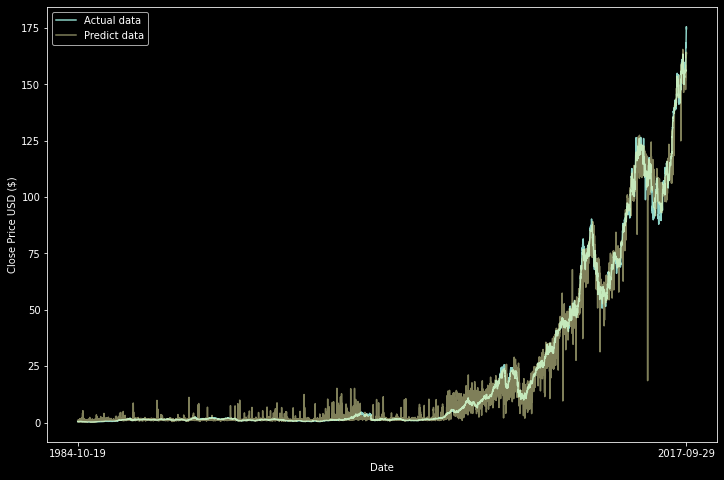

In [201]:
y_val = dfreg_aapl[:-forecast_out]
y_val_pred = model_aapl.predict(X_aapl)
val1 = dfreg_aapl[:-forecast_out].copy()
val1['Label'] = np.ravel(y_val_pred)

plt.figure(figsize=(12,8))
plt.plot(y_val['Label'], label='Actual data')
plt.plot(val1['Label'], label='Predict data', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(y_val.index.values)[0], list(y_val.index.values)[-1]])
plt.legend()
plt.show()

In [202]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_val['Label'])-np.array(y_val_pred)),2)))
print("RMSE of above gragh: " + str(rms))

RMSE of above gragh: 3.5830155077288626


Classification

In [203]:
dfreg_aapl['Label_Reg'] = dfreg_aapl['Label']
dfreg_aapl['Label'] = np.where(dfreg_aapl['Close']>dfreg_aapl['Label'], 0.0, 1.0) # 1.0 = up, 0.0 = down
dfreg_aapl = dfreg_aapl[:-forecast_out]
dfreg_aapl.head(10)


,Close,Volume,HL_Percent,Percent_Change,Month_Percent_Change,Label,Label_Reg
Date,,,,,,,
1984-10-19,0.40853,90949795,7.206325,0.000000,-3.757374,0.0,0.38932
1984-10-22,0.40593,32003288,2.212204,-0.636428,-3.796221,0.0,0.39699
1984-10-23,0.41491,51993625,0.923092,0.000000,-3.400738,1.0,0.41618
1984-10-24,0.41874,46577491,1.227492,0.000000,0.611358,1.0,0.43668
1984-10-25,0.40339,44109940,3.805251,-3.665759,-8.894618,1.0,0.43540
1984-10-26,0.39316,32028264,2.932648,-2.536007,-13.353342,1.0,0.42646
1984-10-29,0.39443,14124427,0.649038,0.000000,-15.909033,1.0,0.42134
1984-10-30,0.39956,20802447,0.958554,0.000000,-10.251276,1.0,0.40724
1984-10-31,0.39699,16798133,1.612131,-0.643208,-8.710547,1.0,0.41111


In [204]:
# Scale the X so that everyone can have the same distribution for linear regression
X_aapl = np.array(dfreg_aapl.drop(['Label', 'Label_Reg'], axis=1))
scaler = preprocessing.StandardScaler()
X_aapl = scaler.fit_transform(X_aapl)

# Separate label and identify it as y
y_aapl = np.array(dfreg_aapl['Label'])

# Separation of training and testing of model by train test split.
X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(X_aapl, y_aapl, test_size=0.2, random_state=0)

Calculate Accuracy, Precision, Recall, F1

In [205]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
knn = KNeighborsClassifier(metric="euclidean")
model_aapl = GridSearchCV(knn, params)
model_aapl.fit(X_train_aapl, y_train_aapl)

model_aapl2 = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
model_aapl2.fit(X_train_aapl, y_train_aapl)

print('kNN accuracy for training set: %f' % model_aapl2.score(X_train_aapl, y_train_aapl))
print('kNN accuracy for test set: %f' % model_aapl2.score(X_test_aapl, y_test_aapl))
model_predicted = model_aapl2.predict(X_test_aapl)
print('acc: %f' % accuracy_score(y_test_aapl, model_predicted))
print('rec: %f' % recall_score(y_test_aapl, model_predicted))
print('pre: %f' % precision_score(y_test_aapl, model_predicted))
print('f1: %f' % f1_score(y_test_aapl, model_predicted))


kNN accuracy for training set: 0.710673
kNN accuracy for test set: 0.589404
acc: 0.589404
rec: 0.733740
pre: 0.632224
f1: 0.679210


Calculate gain

In [206]:
gain = 0.0
count = 0
predict_pointer = 0
predict = model_aapl2.predict(X_aapl)
for index, row in dfreg_aapl.iterrows():
    if predict[predict_pointer] == 1.0:
        count += 1
        gain += row['Label_Reg'] - row['Close']
    predict_pointer += 1

avg_gain = gain/count

print(avg_gain)

1.185864382759845


### 2. MIK

In [207]:
dfreg_mik = df_mik.loc[:,['Close','Volume']]
dfreg_mik['HL_Percent'] = (df_mik['High'] - df_mik['Low']) / df_mik['Close'] * 100.0
dfreg_mik['Percent_Change'] = (df_mik['Close'] - df_mik['Open']) / df_mik['Open'] * 100.0
dfreg_mik['Month_Percent_Change'] = (df_mik['Close'] - df_mik['Close'].shift(30)) / df_mik['Close'] * 100.0

# Drop missing value
dfreg_mik.dropna(subset= ['Month_Percent_Change'], inplace=True)

dfreg_mik.head(10)

,Close,Volume,HL_Percent,Percent_Change,Month_Percent_Change
Date,,,,,
2014-08-11,14.95,694967,2.274247,0.877193,-13.846154
2014-08-12,15.16,972137,2.242744,1.404682,-12.467018
2014-08-13,14.97,230025,2.538410,-0.992063,-12.558450
2014-08-14,14.79,302250,1.893171,-1.268358,-13.319811
2014-08-15,14.89,235135,1.074547,0.812458,-14.372062
2014-08-18,14.77,373415,1.997292,-0.938967,-14.488829
2014-08-19,14.90,285567,1.610738,0.880162,-13.489933
2014-08-20,15.41,293655,4.477612,3.284182,-9.669046
2014-08-21,15.50,315150,3.483871,1.108937,-7.870968


In [208]:
dfreg_mik = df_mik.loc[:,['Close','Volume']]
dfreg_mik['HL_Percent'] = (df_mik['High'] - df_mik['Low']) / df_mik['Close'] * 100.0
dfreg_mik['Percent_Change'] = (df_mik['Close'] - df_mik['Open']) / df_mik['Open'] * 100.0
dfreg_mik['Month_Percent_Change'] = (df_mik['Close'].shift(30) - df_mik['Open']) / df_mik['Open'] * 100.0

# Drop missing value
dfreg_mik.dropna(subset= ['Month_Percent_Change'], inplace=True)

# How many days to forcast (1, 5, 30)
forecast_out = 30

# Separating the label here, we want to predict the future Close
forecast_col = 'Close'
dfreg_mik['Label'] = dfreg_mik[forecast_col].shift(-forecast_out)

dfreg_mik.head(10)

,Close,Volume,HL_Percent,Percent_Change,Month_Percent_Change,Label
Date,,,,,,
2014-08-11,14.95,694967,2.274247,0.877193,14.844804,17.21
2014-08-12,15.16,972137,2.242744,1.404682,14.046823,17.47
2014-08-13,14.97,230025,2.538410,-0.992063,11.441799,17.46
2014-08-14,14.79,302250,1.893171,-1.268358,11.882510,17.44
2014-08-15,14.89,235135,1.074547,0.812458,15.301286,17.53
2014-08-18,14.77,373415,1.997292,-0.938967,13.413816,17.48
2014-08-19,14.90,285567,1.610738,0.880162,14.488829,17.49
2014-08-20,15.41,293655,4.477612,3.284182,13.270777,17.42
2014-08-21,15.50,315150,3.483871,1.108937,9.067189,17.79


In [209]:
# Scale the X so that everyone can have the same distribution for linear regression
X_mik = np.array(dfreg_mik.drop(['Label'], axis=1))
scaler = preprocessing.StandardScaler()
X_mik = scaler.fit_transform(X_mik)

# Find Data Series of late X and early X (train) for model generation and evaluation
X_lately_mik = X_mik[-forecast_out:]
X_mik = X_mik[:-forecast_out]

# Separate label and identify it as y
y_mik = np.array(dfreg_mik['Label'])
y_mik = y_mik[:-forecast_out]

# Separation of training and testing of model by train test split.
X_train_mik, X_test_mik, y_train_mik, y_test_mik = train_test_split(X_mik, y_mik, test_size=0.2, random_state=0)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
knn = KNeighborsRegressor(metric="euclidean")
model_mik = GridSearchCV(knn, params, cv=5)
model_mik.fit(X_train_mik, y_train_mik)

print(model_mik.fit(X_train_mik, y_train_mik).best_params_)

print('kNN RMSE for training set: %f' % math.sqrt(mean_squared_error(y_train_mik, model_mik.predict(X_train_mik))))
print('kNN RMSE for test set: %f' % math.sqrt(mean_squared_error(y_test_mik, model_mik.predict(X_test_mik))))

{'n_neighbors': 6}
kNN RMSE for training set: 1.456904
kNN RMSE for test set: 1.932678


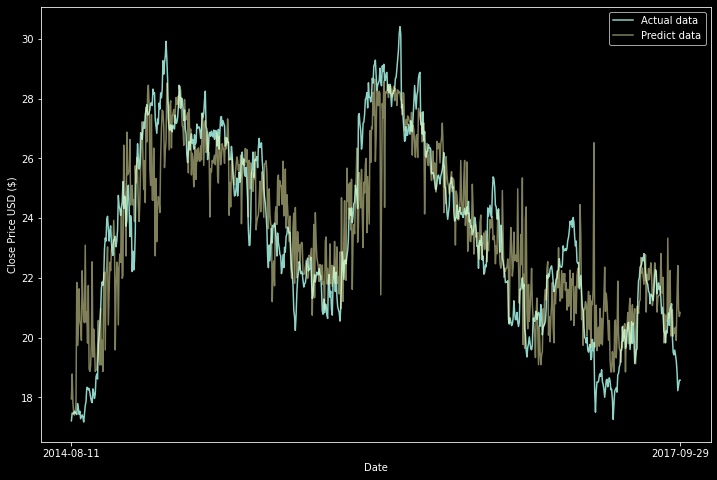

In [210]:
y_val = dfreg_mik[:-forecast_out]
y_val_pred = model_mik.predict(X_mik)
val1 = dfreg_mik[:-forecast_out].copy()
val1['Label'] = np.ravel(y_val_pred)

plt.figure(figsize=(12,8))
plt.plot(y_val['Label'], label='Actual data')
plt.plot(val1['Label'], label='Predict data', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(y_val.index.values)[0], list(y_val.index.values)[-1]])
plt.legend()
plt.show()

In [211]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_val['Label'])-np.array(y_val_pred)),2)))
print("RMSE of above gragh: " + str(rms))

RMSE of above gragh: 1.564073754592921


In [212]:
dfreg_mik['Label_Reg'] = dfreg_mik['Label']
dfreg_mik['Label'] = np.where(dfreg_mik['Close']>dfreg_mik['Label'], 0.0, 1.0) # 1.0 = up, 0.0 = down
dfreg_mik = dfreg_mik[:-forecast_out]
dfreg_mik.head(10)

,Close,Volume,HL_Percent,Percent_Change,Month_Percent_Change,Label,Label_Reg
Date,,,,,,,
2014-08-11,14.95,694967,2.274247,0.877193,14.844804,1.0,17.21
2014-08-12,15.16,972137,2.242744,1.404682,14.046823,1.0,17.47
2014-08-13,14.97,230025,2.538410,-0.992063,11.441799,1.0,17.46
2014-08-14,14.79,302250,1.893171,-1.268358,11.882510,1.0,17.44
2014-08-15,14.89,235135,1.074547,0.812458,15.301286,1.0,17.53
2014-08-18,14.77,373415,1.997292,-0.938967,13.413816,1.0,17.48
2014-08-19,14.90,285567,1.610738,0.880162,14.488829,1.0,17.49
2014-08-20,15.41,293655,4.477612,3.284182,13.270777,1.0,17.42
2014-08-21,15.50,315150,3.483871,1.108937,9.067189,1.0,17.79


In [213]:
# Scale the X so that everyone can have the same distribution for linear regression
X_mik = np.array(dfreg_mik.drop(['Label', 'Label_Reg'], axis=1))
scaler = preprocessing.StandardScaler()
X_mik = scaler.fit_transform(X_mik)

# Separate label and identify it as y
y_mik = np.array(dfreg_mik['Label'])

# Separation of training and testing of model by train test split.
X_train_mik, X_test_mik, y_train_mik, y_test_mik = train_test_split(X_mik, y_mik, test_size=0.2, random_state=0)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
knn = KNeighborsClassifier(metric="euclidean")
model_mik = GridSearchCV(knn, params, cv=5)
model_mik.fit(X_train_mik, y_train_mik)

model_mik2 = KNeighborsClassifier(n_neighbors=6, metric="euclidean")
model_mik2.fit(X_train_mik, y_train_mik)

print('kNN accuracy for training set: %f' % model_mik2.score(X_train_mik, y_train_mik))
print('kNN accuracy for test set: %f' % model_mik2.score(X_test_mik, y_test_mik))
model_predicted = model_mik2.predict(X_test_mik)
print('acc: %f' % accuracy_score(y_test_mik, model_predicted))
print('rec: %f' % recall_score(y_test_mik, model_predicted))
print('pre: %f' % precision_score(y_test_mik, model_predicted))
print('f1: %f' % f1_score(y_test_mik, model_predicted))


kNN accuracy for training set: 0.832543
kNN accuracy for test set: 0.773585
acc: 0.773585
rec: 0.635135
pre: 0.839286
f1: 0.723077


### 3. YPF

In [214]:
dfreg_ypf = df_ypf.loc[:,['Close','Volume']]
dfreg_ypf['HL_Percent'] = (df_ypf['High'] - df_ypf['Low']) / df_ypf['Close'] * 100.0
dfreg_ypf['Percent_Change'] = (df_ypf['Close'] - df_ypf['Open']) / df_ypf['Open'] * 100.0
dfreg_ypf['Month_Percent_Change'] = (df_ypf['Close'] - df_ypf['Close'].shift(30)) / df_ypf['Close'] * 100.0

# Drop missing value
dfreg_ypf.dropna(subset= ['Month_Percent_Change'], inplace=True)

dfreg_ypf = df_ypf.loc[:,['Close','Volume']]
dfreg_ypf['HL_Percent'] = (df_ypf['High'] - df_ypf['Low']) / df_ypf['Close'] * 100.0
dfreg_ypf['Percent_Change'] = (df_ypf['Close'] - df_ypf['Open']) / df_ypf['Open'] * 100.0
dfreg_ypf['Month_Percent_Change'] = (df_ypf['Close'].shift(30) - df_ypf['Open']) / df_ypf['Open'] * 100.0

# Drop missing value
dfreg_ypf.dropna(subset= ['Month_Percent_Change'], inplace=True)

# How many days to forcast (1, 5, 30)
forecast_out = 30

# Separating the label here, we want to predict the future Close
forecast_col = 'Close'
dfreg_ypf['Label'] = dfreg_ypf[forecast_col].shift(-forecast_out)

dfreg_ypf.head(10)

,Close,Volume,HL_Percent,Percent_Change,Month_Percent_Change,Label
Date,,,,,,
2005-04-11,46.961,1598,0.930559,-0.704106,17.725293,44.667
2005-04-12,45.106,7422,4.112535,-3.950086,15.033751,44.658
2005-04-13,45.378,6622,2.893473,1.591779,18.801352,44.667
2005-04-14,44.159,3539,2.459295,-2.192740,16.100024,44.475
2005-04-15,42.915,12445,2.064546,0.000000,23.061866,45.009
2005-04-18,42.968,2511,1.410352,-0.885772,20.974811,44.939
2005-04-19,43.624,1484,1.024665,1.035273,18.665030,45.938
2005-04-20,45.980,10277,4.758591,4.996346,13.797041,45.911
2005-04-21,46.200,2856,0.928571,0.421684,6.229622,45.674


In [215]:
# Scale the X so that everyone can have the same distribution for linear regression
X_ypf = np.array(dfreg_ypf.drop(['Label'], axis=1))
scaler = preprocessing.StandardScaler()
X_ypf = scaler.fit_transform(X_ypf)
#X = preprocessing.scale(X)

# Find Data Series of late X and early X (train) for model generation and evaluation
X_lately_ypf = X_ypf[-forecast_out:]
X_ypf = X_ypf[:-forecast_out]

# Separate label and identify it as y
y_ypf = np.array(dfreg_ypf['Label'])
y_ypf = y_ypf[:-forecast_out]

# Separation of training and testing of model by train test split.
X_train_ypf, X_test_ypf, y_train_ypf, y_test_ypf = train_test_split(X_ypf, y_ypf, test_size=0.2, random_state=0)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
knn = KNeighborsRegressor(metric="euclidean")
model_ypf = GridSearchCV(knn, params, cv=5)
model_ypf.fit(X_train_ypf, y_train_ypf)

print(model_ypf.fit(X_train_ypf, y_train_ypf).best_params_)

print('kNN RMSE for training set: %f' % math.sqrt(mean_squared_error(y_train_ypf, model_ypf.predict(X_train_ypf))))
print('kNN RMSE for test set: %f' % math.sqrt(mean_squared_error(y_test_ypf, model_ypf.predict(X_test_ypf))))

{'n_neighbors': 7}
kNN RMSE for training set: 3.400897
kNN RMSE for test set: 3.973917


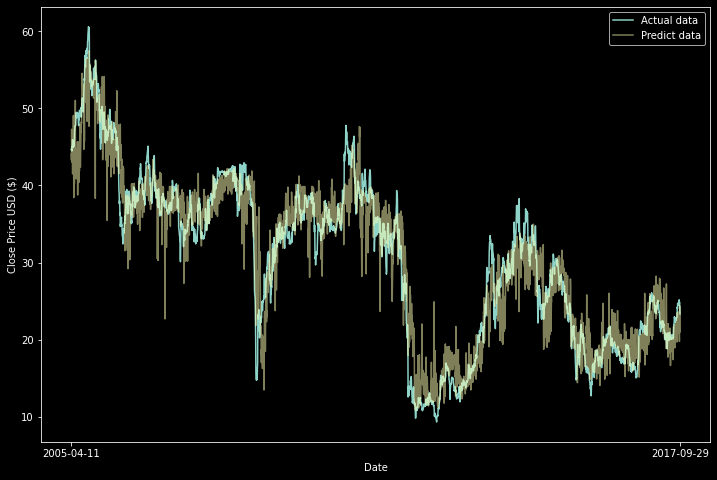

In [216]:
y_val = dfreg_ypf[:-forecast_out]
y_val_pred = model_ypf.predict(X_ypf)
val1 = dfreg_ypf[:-forecast_out].copy()
val1['Label'] = np.ravel(y_val_pred)

plt.figure(figsize=(12,8))
plt.plot(y_val['Label'], label='Actual data')
plt.plot(val1['Label'], label='Predict data', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(y_val.index.values)[0], list(y_val.index.values)[-1]])
plt.legend()
plt.show()

In [217]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_val['Label'])-np.array(y_val_pred)),2)))
print("RMSE of above gragh: " + str(rms))

RMSE of above gragh: 3.522965433268247


In [218]:
dfreg_ypf['Label_Reg'] = dfreg_ypf['Label']
dfreg_ypf['Label'] = np.where(dfreg_ypf['Close']>dfreg_ypf['Label'], 0.0, 1.0) # 1.0 = up, 0.0 = down
dfreg_ypf = dfreg_ypf[:-forecast_out]
dfreg_ypf.head(10)

,Close,Volume,HL_Percent,Percent_Change,Month_Percent_Change,Label,Label_Reg
Date,,,,,,,
2005-04-11,46.961,1598,0.930559,-0.704106,17.725293,0.0,44.667
2005-04-12,45.106,7422,4.112535,-3.950086,15.033751,0.0,44.658
2005-04-13,45.378,6622,2.893473,1.591779,18.801352,0.0,44.667
2005-04-14,44.159,3539,2.459295,-2.192740,16.100024,1.0,44.475
2005-04-15,42.915,12445,2.064546,0.000000,23.061866,1.0,45.009
2005-04-18,42.968,2511,1.410352,-0.885772,20.974811,1.0,44.939
2005-04-19,43.624,1484,1.024665,1.035273,18.665030,1.0,45.938
2005-04-20,45.980,10277,4.758591,4.996346,13.797041,0.0,45.911
2005-04-21,46.200,2856,0.928571,0.421684,6.229622,0.0,45.674


In [219]:
# Scale the X so that everyone can have the same distribution for linear regression
X_ypf = np.array(dfreg_ypf.drop(['Label', 'Label_Reg'], axis=1))
scaler = preprocessing.StandardScaler()
X_ypf = scaler.fit_transform(X_ypf)

# Separate label and identify it as y
y_ypf = np.array(dfreg_ypf['Label'])

# Separation of training and testing of model by train test split.
X_train_ypf, X_test_ypf, y_train_ypf, y_test_ypf = train_test_split(X_ypf, y_ypf, test_size=0.2, random_state=0)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
knn = KNeighborsClassifier(metric="euclidean")
model_ypf = GridSearchCV(knn, params, cv=5)
model_ypf.fit(X_train_ypf, y_train_ypf)

model_ypf2 = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
model_ypf2.fit(X_train_ypf, y_train_ypf)

print('kNN accuracy for training set: %f' % model_ypf2.score(X_train_ypf, y_train_ypf))
print('kNN accuracy for test set: %f' % model_ypf2.score(X_test_ypf, y_test_ypf))
model_predicted = model_ypf2.predict(X_test_ypf)
print('acc: %f' % accuracy_score(y_test_ypf, model_predicted))
print('rec: %f' % recall_score(y_test_ypf, model_predicted))
print('pre: %f' % precision_score(y_test_ypf, model_predicted))
print('f1: %f' % f1_score(y_test_ypf, model_predicted))

kNN accuracy for training set: 0.748010
kNN accuracy for test set: 0.646497
acc: 0.646497
rec: 0.696875
pre: 0.640805
f1: 0.667665
